In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import percentileofscore



import torch
from torch.optim import Adam
from sklearn.gaussian_process import GaussianProcessRegressor


import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer 

from moses.metrics import QED, SA, logP
from moses.utils import get_mol


from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit import rdBase
#from rdkit import RDLogger

rdBase.DisableLog('rdApp.*')

import zipfile
from io import BytesIO

import selfies as sf



c:\Users\lisa0\anaconda3\envs\LG_newmoses\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Try out with molecules

In [2]:
train_df = pd.read_csv("../gpr/optimize_gpr/gpr_fit_ZINC250K_df.csv")[:1000]
test_df = pd.read_csv("../gpr/optimize_gpr/gpr_test_ZINC250K_df.csv")
start_df = pd.read_csv("../gpr/optimize_gpr/opt_start_ZINC250K_10pct_df.csv")


In [3]:
print(f'gpr train: {train_df.shape}')
print(f'gpr test: {test_df.shape}')
print(f'gpr start: {start_df.shape}')

gpr train: (1000, 6)
gpr test: (1000, 6)
gpr start: (400, 6)


In [4]:
model_name = 'SELF_VAEProp_obj_w0.1_1000train_10pct'
folder_path = "../checkpoints/ZINC250K_vae_property_obj_proploss_w0.1_SELF"
config = torch.load(f'{folder_path}/vae_property_config.pt')
vocab = torch.load(f'{folder_path}/vae_property_vocab.pt')

print(f"Use Selfies: {config.use_selfies}")

Use Selfies: True


In [5]:
config.reg_prop_tasks

['obj']

In [6]:
cols = ['SELFIES' if config.use_selfies else 'SMILES', 'logP', 'qed', 'SAS', 'obj']
train_data = train_df[cols].values
test_data = test_df[cols].values
start_data = start_df[cols].values


model_path = f'{folder_path}/vae_property_model_080.pt'


model = VAEPROPERTY(vocab, config)
model.load_state_dict(torch.load(model_path))

trainer = VAEPROPERTYTrainer(config)
train_loader = trainer.get_dataloader(model, train_data, shuffle=False)
test_loader = trainer.get_dataloader(model, test_data, shuffle=False)
start_loader = trainer.get_dataloader(model, start_data, shuffle=False)

In [7]:
train_data.shape

(1000, 5)

In [8]:
model.eval()

x_list = []
z_list = []
mu_list = []
logvar_list = []
y_list = []


# y_list = y_list.squeeze()

for step, batch in enumerate(train_loader):
    x = batch[0]
    y = batch[1]
    x_list.extend(x)
    y_list.extend(np.array(y).squeeze())

    mu, logvar, z, _ = model.forward_encoder(x)
    z_list.extend(z.detach().cpu().numpy())
    mu_list.extend(mu.detach().cpu().numpy())
    logvar_list.extend(logvar.detach().cpu().numpy())



y_list = np.array(y_list).squeeze()
GP_train_y = y_list.reshape(-1, y_list.shape[-1])

train_data_df = pd.DataFrame(GP_train_y, columns=['logP', 'qed', 'SAS', 'obj'])
train_data_df = pd.DataFrame({'z': z_list, 'mu': mu_list, 'logvar': logvar_list})
train_data_df.insert(0, 'SELFIES' if config.use_selfies else 'SMILES', [vocab.ids2string(point.cpu().detach().numpy()) for point in x_list])

GP_train_y = GP_train_y[:, 3]
GP_train_X = np.array(mu_list)

c:\Users\lisa0\24-1 UofT\LG AI lab\NewMoses\notebooks\..\moses\vae_property\trainer.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  y_tensors = torch.tensor(y_sorted, dtype=torch.float32, device=device)


In [9]:
train_data_df.head()

,SELFIES,z,mu,logvar
0,[C][C][C][=C][Branch1][C][N][C][=N][N][=C][Bra...,"[-1.4328864, 0.44459584, -1.5432234, 1.9056351...","[0.0143776005, 0.03507651, 0.01807816, -0.0029...","[-0.0013949885, -0.004070854, -0.004591463, -0..."
1,[C][C][=N][N][Branch1][C][C][C][=Branch1][C][=...,"[0.6684161, 0.6260653, -1.4543084, 1.5720875, ...","[0.004036524, 0.01609119, 0.00092794, -0.01651...","[4.3450855e-06, -0.0026172278, 9.011477e-06, -..."
2,[C][C][=Branch1][C][=O][N][Branch1][C][C][C][C...,"[-0.35864434, -1.0216761, 0.118621916, -0.8376...","[0.029700495, 0.012834952, 0.0074992143, -0.01...","[5.46854e-05, -0.0064363806, 0.00015266612, -0..."
3,[O][=C][Branch2][Ring1][S][C][C][C][=Branch1][...,"[-0.8148012, 0.008120799, 0.7383895, -0.337787...","[0.019519318, 0.035259616, 0.033136234, -0.006...","[0.0026700445, -0.00085179694, -0.005062746, -..."
4,[C][C][=C][C][=C][Branch2][Ring1][=N][N][C][C]...,"[0.4113555, 0.92880875, -1.4528434, -2.5380466...","[0.0035796016, 0.02155492, 0.026701722, -0.000...","[-0.0015759841, -0.009963996, -0.0056179967, -..."


In [10]:
model.eval()

x_list = []
z_list = []
mu_list = []
logvar_list = []
y_list = []



# y_list = y_list.squeeze()

for step, batch in enumerate(start_loader):
    x = batch[0]
    y = batch[1]
    x_list.extend(x)
    y_list.extend(np.array(y).squeeze())

    mu, logvar, z, _ = model.forward_encoder(x)
    z_list.extend(z.detach().cpu().numpy())
    mu_list.extend(mu.detach().cpu().numpy())
    logvar_list.extend(logvar.detach().cpu().numpy())



rest_X = np.array(mu_list).squeeze()
y_list = np.array(y_list).squeeze()
rest_y = y_list.reshape(-1, y_list.shape[-1])

start_data_df = pd.DataFrame(rest_y, columns=['logP', 'qed', 'SAS', 'obj'])
start_data_df = pd.DataFrame({'z': z_list, 'mu': mu_list, 'logvar': logvar_list})
start_data_df.insert(0, 'SELFIES' if config.use_selfies else 'SMILES', [vocab.ids2string(point.detach().cpu().numpy()) for point in x_list])

rest_y = rest_y[:, 3]

In [11]:
start_data_df.head()

,SELFIES,z,mu,logvar
0,[C][C][=N][C][Branch2][Ring2][Ring1][C][=C][C]...,"[0.319954, -0.307076, 0.088105604, 0.6661274, ...","[0.011852212, 0.040086605, 0.016223159, -0.018...","[0.003428433, -0.004055842, -0.0021486338, -0...."
1,[C][=C][C][N][C][=Branch1][C][=O][C][=C][Branc...,"[0.055645224, 1.2308388, 1.0071595, -1.3514771...","[0.018605188, 0.051281605, 0.03321043, -0.0030...","[0.0020044514, -0.004599535, -0.0015993733, -0..."
2,[C][C][=C][C][=C][Branch2][Ring2][C][C][N][C][...,"[-0.7838888, 1.5771217, -0.69960994, 2.0550635...","[0.009520685, 0.040554646, 0.026390517, -0.011...","[0.00051229727, -0.0068022655, -0.004183624, -..."
3,[C][C][=C][C][=C][NH1][C][Branch2][Ring1][O][C...,"[0.7511027, 0.79957783, 1.2125667, -2.8970933,...","[0.008003103, 0.043445397, 0.03855169, 0.00904...","[0.00010913657, -0.005463943, -0.005928127, -0..."
4,[C][C][=C][C][=C][C][Branch2][Ring1][P][C][=C]...,"[-0.37737763, -0.7077363, -0.81560975, -0.3721...","[0.009970249, 0.051766925, 0.027822142, -0.014...","[-0.002168165, -0.009880357, -0.004570566, -0...."


In [12]:
start_data_df.shape, train_data_df.shape

((400, 4), (1000, 4))

In [13]:
#def f(x):
#    # 임의의 함수 예시 (사용자가 원하는 함수로 대체)
#    return -np.sum((x - 2)**2)

# Numerical gradient 계산 함수
def numerical_gradient(f, clf, x, epsilon=1e-8):
    grad = np.zeros_like(x)
    x_plus = x.copy()
    x_minus = x.copy()
    x_plus += epsilon
    x_minus -= epsilon
    
    grad = (f(x_plus.reshape(1,-1), clf) - f(x_minus.reshape(1,-1), clf)) / (2 * epsilon)
    return grad

# Adam Optimizer for Gradient Ascent
def adam_gradient_ascent(f, clf, initial_x, learning_rate=0.01, max_iter=1000, tolerance=1e-9, beta1=0.9, beta2=0.999, epsilon=1e-8):
    x = initial_x
    m = np.zeros_like(x)  # Initialize the first moment vector
    v = np.zeros_like(x)  # Initialize the second moment vector
    t = 0  # Initialize timestep

    for i in range(max_iter):
        t += 1
        grad = numerical_gradient(f, clf, x)
        
        m = beta1 * m + (1 - beta1) * grad  # Update biased first moment estimate
        v = beta2 * v + (1 - beta2) * (grad ** 2)  # Update biased second moment estimate

        m_hat = m / (1 - beta1 ** t)  # Compute bias-corrected first moment estimate
        v_hat = v / (1 - beta2 ** t)  # Compute bias-corrected second moment estimate

        new_x = x + learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)  # Update the parameters
        
        # 수렴 조건 체크
        if np.linalg.norm(new_x - x) < tolerance:
            break
        x = new_x
       # print(f"Iteration {i+1}: x = {x}, f(x) = {f(x)}")
    
    return x

In [14]:
#train_mu = np.vstack(train_data_df['mu'].values)
#train_logvar = np.vstack(train_data_df['logvar'].values)
#
#n_sample = 100
#
##train_mu = train_data_df['mu'].values
##train_logvar = train_data_df['logvar'].values
#
##train_mu = np.array([mu for mu in train_mu])
##train_logvar = np.array([logvar for logvar in train_logvar])
#
#GP_train_X = np.array([mu + np.exp(logvar / 2) * np.random.randn(n_sample, mu.shape[-1]) for mu, logvar in zip(train_mu, train_logvar)])
#GP_train_X = GP_train_X.reshape(-1, GP_train_X.shape[-1])
#print(GP_train_X.shape)
#GP_train_y = np.array([y for y in GP_train_y for _ in range(n_sample)])

In [15]:
clf = GaussianProcessRegressor(random_state=42)
clf.fit(GP_train_X, GP_train_y)

GaussianProcessRegressor(random_state=42)

In [16]:
#start_mu = np.vstack(start_data_df['mu'].values)
#start_logvar = np.vstack(start_data_df['logvar'].values)
#print(start_mu.shape)
#rest_X = np.array([mu + np.exp(logvar / 2) * np.random.randn(1, mu.shape[-1]) for mu, logvar in zip(start_mu, start_logvar)])
#rest_X = rest_X.reshape(-1, rest_X.shape[-1])
#
#print(rest_X.shape)

print(f"R2 Score: {clf.score(rest_X, rest_y)}")
print(f"R2 Score: {clf.score(GP_train_X, GP_train_y)}")

R2 Score: -1.6121714483756753
R2 Score: 0.9999999999986343


In [17]:
def f(x, gaussian):
    pred_mean = gaussian.predict(x)[0]

    return pred_mean

In [18]:
optimal_z_list = []

# Adam Gradient Ascent 수행
for z in tqdm(rest_X):
    initial_point = np.array(z)
    optimal_z = adam_gradient_ascent(f, clf, initial_point)
    optimal_z_list.append(optimal_z)

100%|██████████| 400/400 [06:32<00:00,  1.02it/s]


In [19]:
np.array(optimal_z_list).shape

(100, 128)

In [20]:
optimal_z_list = torch.tensor(optimal_z_list).float()

In [24]:
torch.save(optimal_z_list, f'../gpr/optimize_gpr/{model_name}_optimal_z.pt')

In [25]:
# save optimal_z_list
#torch.save(optimal_z_list, f'../checkpoints/optimize_gpr/optimal_z_list.pt')
# optimal_z_list = torch.load('../checkpoints/optimize_gpr/optimal_z_list.pt')

In [26]:
#gen_argmax = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, test=True)
#gen_temp_1 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=1)
#gen_temp_point5 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.5)
#gen_temp_point7 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.7)

In [27]:
#gen_temp_point01 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.01)
#gne_temp_point1 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.1)
#gen_temp_point3 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.3)

In [28]:
def create_opt_df(gen_molecule, config, type='opt', start_df=start_df):
    if config.use_selfies:
        opt_df = pd.DataFrame(gen_molecule, columns=['gen_SELFIES'])
        opt_df['gen_SMILES'] = [sf.decoder(s) for s in opt_df['gen_SELFIES']]
    else:
        opt_df = pd.DataFrame(gen_molecule, columns=['gen_SMILES'])
    opt_df['gen_romol'] = [get_mol(mol) for mol in opt_df['gen_SMILES']]
    opt_df = opt_df.dropna(subset=['gen_romol'])

    opt_df['gen_logP'] = [logP(mol) for mol in opt_df['gen_romol']]
    opt_df['gen_qed'] = [QED(mol) for mol in opt_df['gen_romol']]
    opt_df['gen_SAS'] = [SA(mol) for mol in opt_df['gen_romol']]
    opt_df['gen_obj'] = 5*opt_df['gen_qed'] - opt_df['gen_SAS']

    opt_set = set(opt_df["gen_SELFIES" if config.use_selfies else "gen_SMILES"].values)
    print(f'----{type}----')
    print(f'valid: {len(opt_df)}/{len(start_df)}')
    print(f'unique: {len(opt_set)}/{len(opt_df)}')


    return opt_df

In [22]:
# ignore the error of rdkit
from rdkit import rdBase
#from rdkit import RDLogger

rdBase.DisableLog('rdApp.*')
#rdBase.EnableLog('rdApp.*') 

In [23]:
zinc_df = pd.read_csv('../moses/dataset/data/ZINC250K/train.csv')
#test_df = pd.read_csv('../moses/dataset/data/ZINC250K/test.csv')
# concat zinc_df with test_df
#zinc_df = pd.concat([zinc_df, test_df], axis=0)
zinc_df.shape

(250000, 6)

In [44]:
def plot_violins(temps):
    plt.figure(figsize=(12, 6))
    for idx, temp in enumerate(temps):
        temp = round(temp, 2)
        gen = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=temp)
        gen_df = create_opt_df(gen, config, type=f'temp {temp}')
        pct_df = pd.DataFrame({'obj_pct': [percentileofscore(zinc_df['obj'], obj) for obj in set(gen_df['gen_obj'])]})

        sns.violinplot(x=idx, y='obj_pct', data=pct_df, cut=1)

    plt.xticks([idx for idx in range(len(temps))], [round(temp,2) for temp in temps])
    plt.ylabel('objective percentile')

    plt.show()
    return plt, pct_df




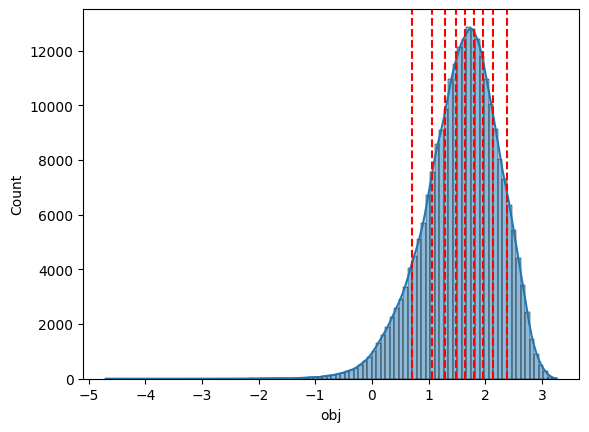

In [49]:
sns.histplot(zinc_df['obj'], bins=100, kde=True)
# show 10, 20, 30, 40, 50, 60, 70, 80, 90 percentile
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]
percentile_values = [np.percentile(zinc_df['obj'], p) for p in percentiles]
percentile_values
# plot it on the sns.histplot
for percentile_value in percentile_values:
    plt.axvline(percentile_value, color='r', linestyle='--')
plt.show()


----temp 0.01----
valid: 100/100
unique: 2/100
----temp 0.02----
valid: 100/100
unique: 2/100
----temp 0.03----
valid: 100/100
unique: 2/100
----temp 0.04----
valid: 100/100
unique: 4/100
----temp 0.05----
valid: 100/100
unique: 5/100
----temp 0.06----
valid: 100/100
unique: 10/100
----temp 0.07----
valid: 100/100
unique: 11/100
----temp 0.08----
valid: 100/100
unique: 19/100
----temp 0.09----
valid: 100/100
unique: 17/100
----temp 0.1----
valid: 100/100
unique: 27/100


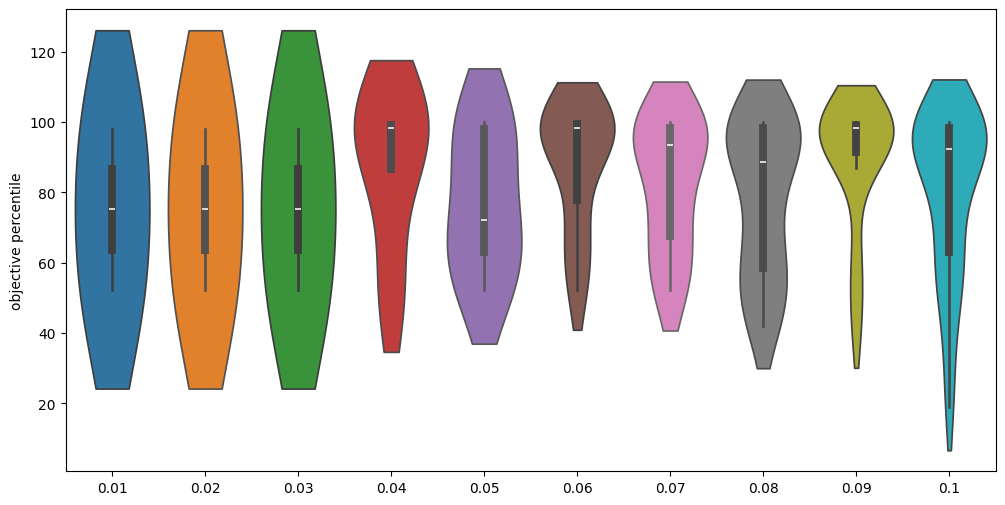

In [45]:
temps = np.linspace(0.01, 0.1, 10)
plt, pct_df =plot_violins(temps)

In [34]:
pct_df

,obj_pct
0,52.3204
1,98.1396
2,99.8556
3,97.9992
4,99.9296
5,78.2780
6,92.3652
7,95.4576
8,45.5028
9,98.9048


----temp 0.1----
valid: 100/100
unique: 25/100
----temp 0.2----
valid: 100/100
unique: 66/100
----temp 0.3----
valid: 100/100
unique: 97/100
----temp 0.4----
valid: 100/100
unique: 100/100
----temp 0.5----
valid: 100/100
unique: 100/100
----temp 0.6----
valid: 99/100
unique: 99/99
----temp 0.7----
valid: 97/100
unique: 97/97
----temp 0.8----
valid: 98/100
unique: 98/98
----temp 0.9----
valid: 96/100
unique: 96/96
----temp 1.0----
valid: 93/100
unique: 93/93


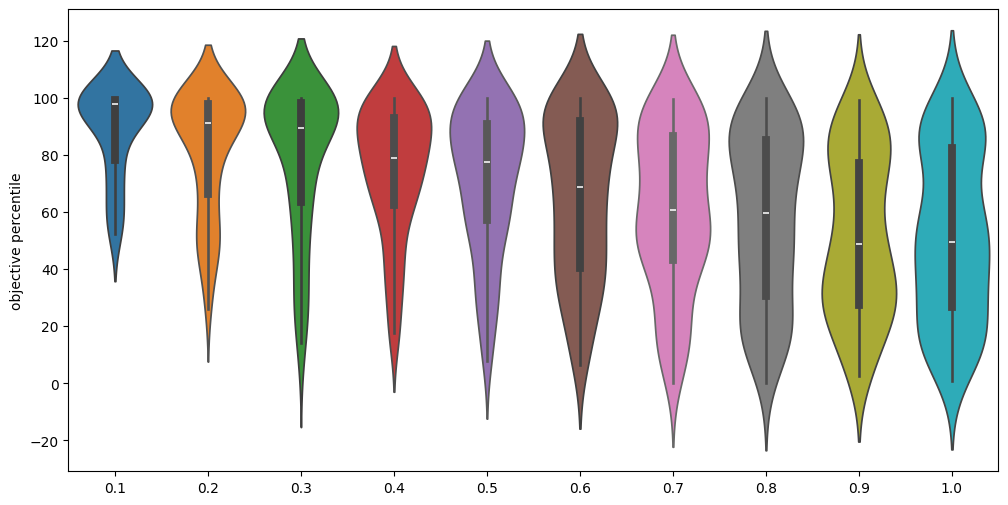

<module 'matplotlib.pyplot' from 'c:\\Users\\lisa0\\anaconda3\\envs\\LG_newmoses\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [31]:
temps = np.linspace(0.1, 1, 10)
plot_violins(temps)

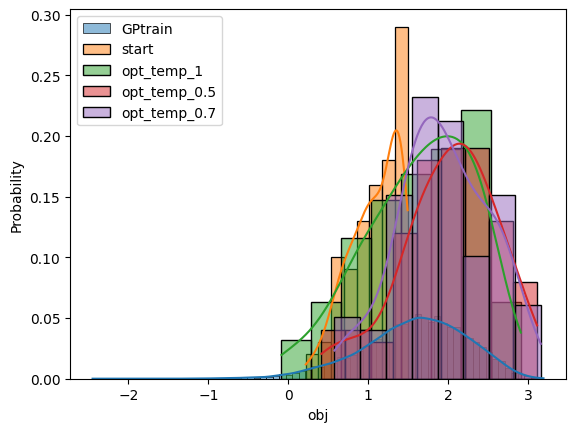

In [109]:
sns.histplot(train_data_df['obj'], kde=True, label='GPtrain', stat='probability')
sns.histplot(start_data_df['obj'], kde=True, label='start', stat='probability')
#sns.histplot(opt_argmax_df['gen_obj'], kde=True, label='opt_arg', stat='probability')
sns.histplot(opt_temp_1_df['gen_obj'], kde=True, label='opt_temp_1', stat='probability')
sns.histplot(opt_temp_point5_df['gen_obj'], kde=True, label='opt_temp_0.5', stat='probability')
sns.histplot(opt_temp_point7_df['gen_obj'], kde=True, label='opt_temp_0.7', stat='probability')
plt.legend()
plt.show()

In [111]:
train_df.shape

(10000, 6)

In [160]:
pct_df = pd.DataFrame({'obj_pct': [percentileofscore(train_df['obj'], obj) for obj in set(opt_argmax_df['gen_obj'])]})
pct_df


,obj_pct
0,53.23


[22:22:34] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 23
[22:22:34] SMILES Parse Error: unclosed ring for input: 'Cc1cnc(N2CC3CC(C(=O)Nc4ccccc4)C(C(C)C)C3O)nc1=O'
[22:22:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 22 23
c:\Users\lisa0\anaconda3\envs\LG_newmoses\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


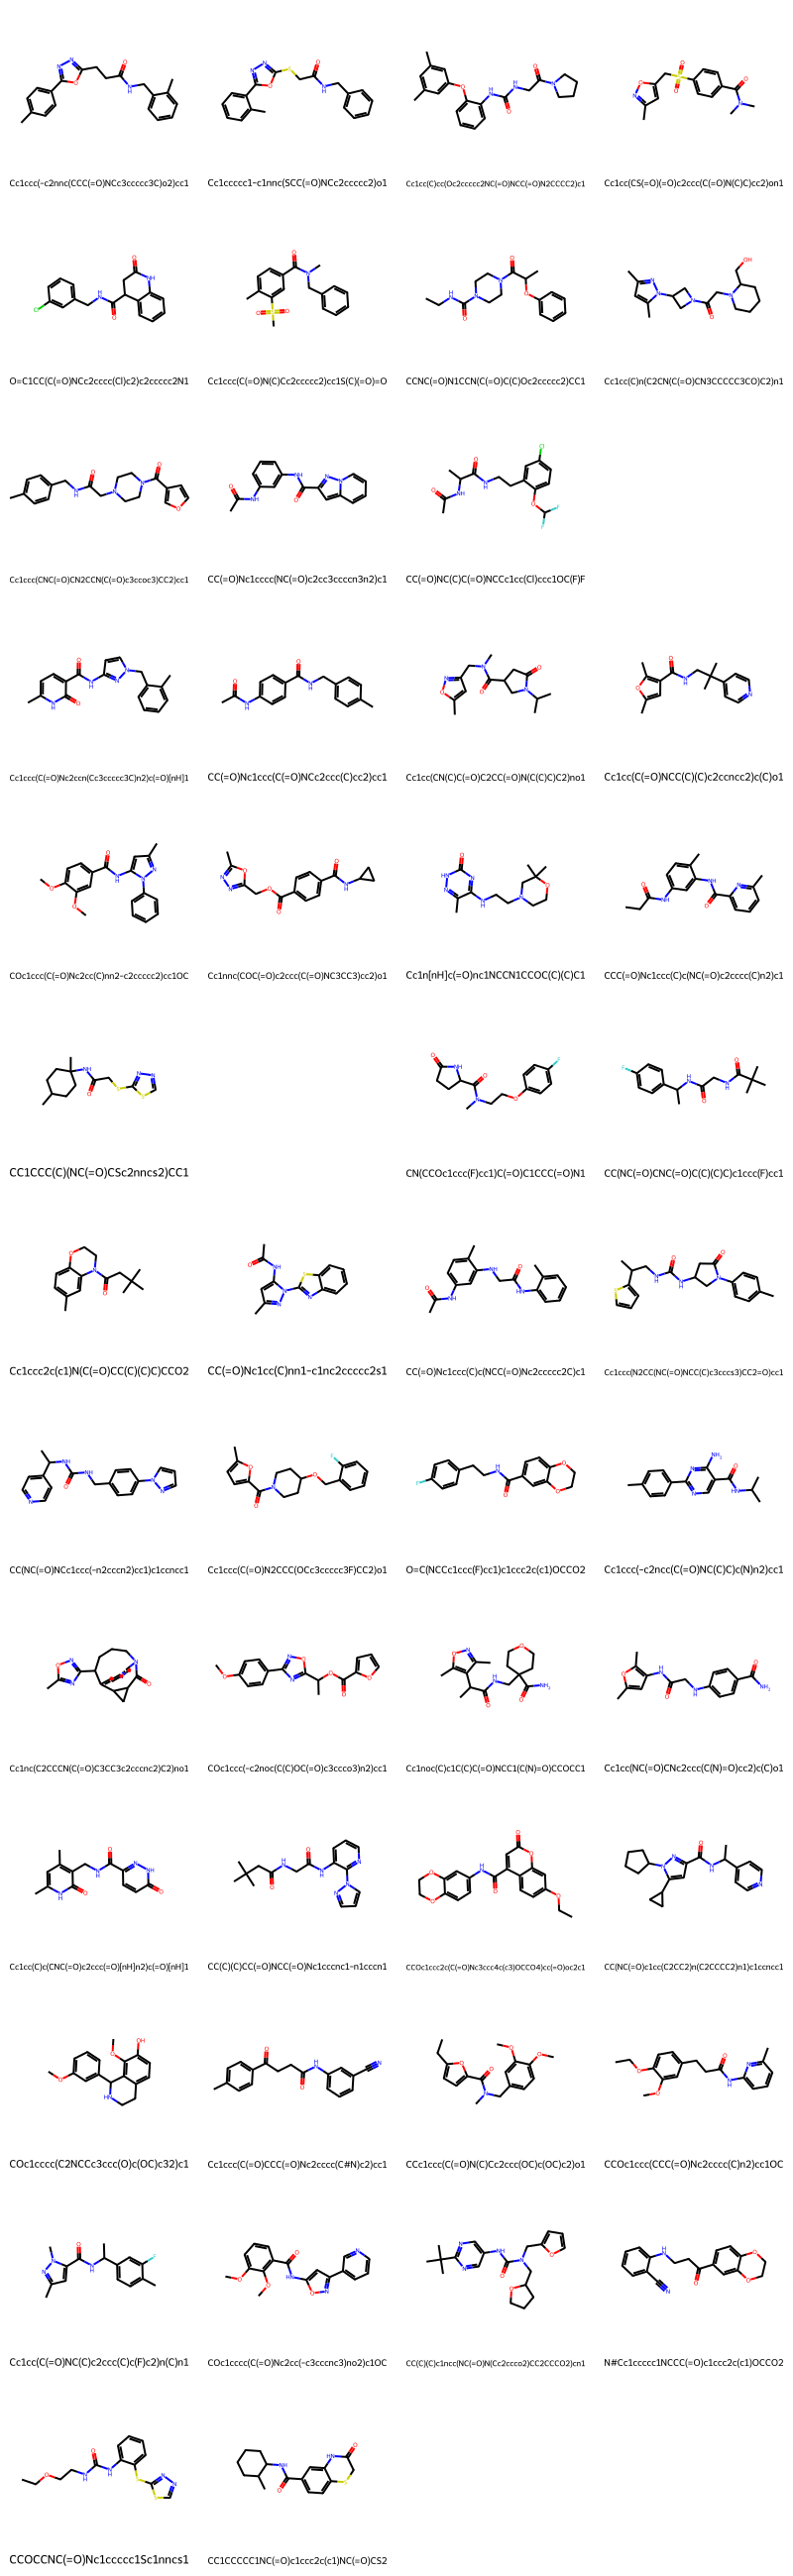

In [ ]:
if config.use_selfies:
    
    viz_df = pd.DataFrame({"SELFIES": gen_molecule_argmax})

    smiles = []
    for selfies in viz_df['SELFIES']:
        smiles.append(sf.decoder(selfies))

    viz_df['RoMol'] = smiles
    viz_df['RoMol'] = viz_df['RoMol'].apply(Chem.MolFromSmiles)
    display(PandasTools.FrameToGridImage(viz_df, column='RoMol', legendsCol='SELFIES', molsPerRow=4))
else:
    viz_df = pd.DataFrame({"SMILES": gen_molecule})
    viz_df['RoMol'] = viz_df['SMILES'].apply(Chem.MolFromSmiles)
    display(PandasTools.FrameToGridImage(viz_df, column='RoMol', legendsCol='SMILES', molsPerRow=4))